In [96]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from prophet import Prophet
from scipy import stats
from pathlib import Path


In [97]:
#import data
coffee_data = Path('Resources/coffee-shop-sales-revenue.csv')

print(coffee_data)

Resources/coffee-shop-sales-revenue.csv


In [98]:
#Read in the data
coffee_df = pd.read_csv(coffee_data, sep='|')

#Print out the first and last five rows
display(coffee_df.head(2))
display(coffee_df.tail(2))

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup


In [99]:
#Clean the data

#Check for nulls
display(coffee_df.isnull().mean() * 100)

#remove nulls
coffee_df = coffee_df.dropna()

#Check for duplicates
display(coffee_df.duplicated().sum())

#Remove duplicates
coffee_df = coffee_df.drop_duplicates()

#Combine date and time columns into new column
coffee_df['salesdatetime'] = coffee_df['transaction_date'].astype(str) + ' ' + coffee_df['transaction_time'].astype(str)

#Convert new column to datetime
coffee_df['salesdatetime'] = pd.to_datetime(coffee_df['salesdatetime'])

#Check data types
display(coffee_df.dtypes)

#Print out the first and last five rows
display(coffee_df.head(2))
display(coffee_df.tail(2))


transaction_id      0.0
transaction_date    0.0
transaction_time    0.0
transaction_qty     0.0
store_id            0.0
store_location      0.0
product_id          0.0
unit_price          0.0
product_category    0.0
product_type        0.0
product_detail      0.0
dtype: float64

0

transaction_id               int64
transaction_date            object
transaction_time            object
transaction_qty              int64
store_id                     int64
store_location              object
product_id                   int64
unit_price                 float64
product_category            object
product_type                object
product_detail              object
salesdatetime       datetime64[ns]
dtype: object

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06-30 20:57:19
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,2023-06-30 20:57:19


In [100]:
#Create a new column for total sales
coffee_df['totalsales'] = coffee_df['transaction_qty'] * coffee_df['unit_price']

#Create a new column for month
coffee_df['month'] = coffee_df['salesdatetime'].dt.month

#print(coffee_df['month'])
#print(coffee_df['salesdatetime'].dt.year)
#print(coffee_df['salesdatetime'].dt.day)
#Create a new column for the week of the year
coffee_df['weekofyear'] = pd.to_datetime(coffee_df['salesdatetime']).dt.strftime('%U')

#Create a new column for day of week
coffee_df['dayofweek'] = coffee_df['salesdatetime'].dt.dayofweek

#Create a new column for hour
coffee_df['hour'] = coffee_df['salesdatetime'].dt.hour

#Print out the first and last 2 rows
display(coffee_df.head(2))
display(coffee_df.tail(2))



,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime,totalsales,month,weekofyear,dayofweek,hour
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11,6.0,1,01,6,7
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56,6.2,1,01,6,7


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,salesdatetime,totalsales,month,weekofyear,dayofweek,hour
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06-30 20:57:19,3.75,6,26,4,20
149115,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,2023-06-30 20:57:19,1.60,6,26,4,20


In [101]:
#Create a dataframe for each store
store1_df = coffee_df.loc[coffee_df['store_id'] == 3]
store2_df = coffee_df.loc[coffee_df['store_id'] == 5]
store3_df = coffee_df.loc[coffee_df['store_id'] == 8]

#Reset the index for each store to sale datetime
store1_df = store1_df.set_index('salesdatetime')
store2_df = store2_df.set_index('salesdatetime')
store3_df = store3_df.set_index('salesdatetime')


#Print out the first and last 2 rows of each store
display(store1_df.head(2))
display(store1_df.tail(2))

display(store2_df.head(2))
display(store2_df.tail(2))

display(store3_df.head(2))
display(store3_df.tail(2))



,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 11:01:48,106,2023-01-01,11:01:48,1,3,Astoria,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.00,1,01,6,11
2023-01-01 11:01:58,107,2023-01-01,11:01:58,1,3,Astoria,38,3.75,Coffee,Barista Espresso,Latte,3.75,1,01,6,11


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 19:57:49,149448,2023-06-30,19:57:49,2,3,Astoria,54,2.50,Tea,Brewed Chai tea,Morning Sunrise Chai Rg,5.00,6,26,4,19
2023-06-30 19:57:49,149449,2023-06-30,19:57:49,1,3,Astoria,70,3.25,Bakery,Scone,Cranberry Scone,3.25,6,26,4,19


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 07:06:11,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,1,01,6,7
2023-01-01 07:08:56,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,1,01,6,7


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 19:40:09,149435,2023-06-30,19:40:09,2,5,Lower Manhattan,58,3.5,Drinking Chocolate,Hot chocolate,Dark chocolate Rg,7.0,6,26,4,19
2023-06-30 20:16:31,149451,2023-06-30,20:16:31,2,5,Lower Manhattan,42,2.5,Tea,Brewed herbal tea,Lemon Grass Rg,5.0,6,26,4,20


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-01-01 08:00:18,18,2023-01-01,08:00:18,1,8,Hell's Kitchen,42,2.5,Tea,Brewed herbal tea,Lemon Grass Rg,2.5,1,01,6,8
2023-01-01 08:00:39,19,2023-01-01,08:00:39,2,8,Hell's Kitchen,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,1,01,6,8


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,totalsales,month,weekofyear,dayofweek,hour
salesdatetime,,,,,,,,,,,,,,,,
2023-06-30 20:57:19,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,3.75,6,26,4,20
2023-06-30 20:57:19,149456,2023-06-30,20:57:19,2,8,Hell's Kitchen,64,0.80,Flavours,Regular syrup,Hazelnut syrup,1.60,6,26,4,20


In [102]:
#Create a custom function to sum total sales
def sum_totalsales(df):
    return df['totalsales'].sum()

#create a custom function to calculate average sales
def avg_totalsales(df):
    return df['totalsales'].mean()

#Create a custom function to categorize weekdays and weekends
def categorize_day(day):
    if day in [0,6]:
        return "Weekend"
    else:
        return "Weekday"


In [103]:
#Create a dataframe for each store's total sales using the custom function by month
store1_totalsales = store1_df.groupby('month').apply(sum_totalsales)
store2_totalsales = store2_df.groupby('month').apply(sum_totalsales)
store3_totalsales = store3_df.groupby('month').apply(sum_totalsales)

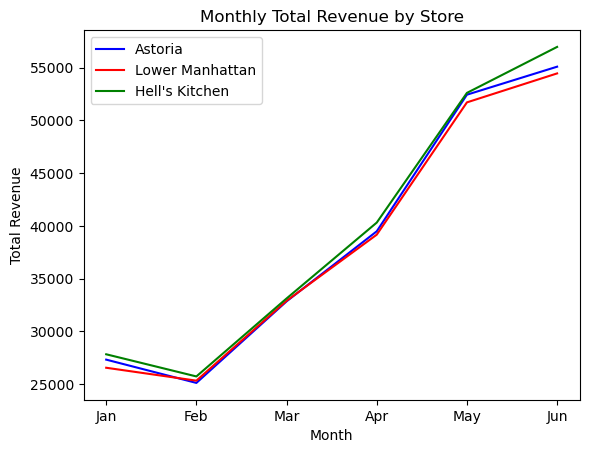

<Figure size 6000x1000 with 0 Axes>

In [104]:
#Display the total sales for each store as a line graph
plt.plot(store1_totalsales, label='Astoria', color='blue')
plt.plot(store2_totalsales, label='Lower Manhattan', color='red')
plt.plot(store3_totalsales, label="Hell's Kitchen", color='green')

#Change the x-axis to display the month name
plt.xticks(store1_totalsales.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])


plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Monthly Total Revenue by Store')
plt.legend(loc='best')
plt.figure(figsize=(60,10))

plt.show()


In [105]:
#total revenue by store - weekend vs weekday

store1_df['Day Category'] = store1_df['dayofweek'].apply(categorize_day)
store2_df['Day Category']= store2_df['dayofweek'].apply(categorize_day)
store3_df['Day Category'] = store3_df['dayofweek'].apply(categorize_day)


#number of weekdays and weekend days between jan 1 and june 30 2023
weekday_count = 130
weekend_count = 51


#groupby day category and calculate total revenue by store for weekends and weekdays
store1_daycategory_avgsales = store1_df.groupby('Day Category').apply(sum_totalsales) 
store2_daycategory_avgsales = store2_df.groupby('Day Category').apply(sum_totalsales)
store3_daycategory_avgsales = store3_df.groupby('Day Category').apply(sum_totalsales)

#calculate weekday averages
store1_weekday_avg_total_revenue = store1_daycategory_avgsales['Weekday'] / weekday_count
store2_weekday_avg_total_revenue = store2_daycategory_avgsales['Weekday'] / weekday_count
store3_weekday_avg_total_revenue = store3_daycategory_avgsales['Weekday'] / weekday_count

#calculate weekend averages
store1_weekend_avg_total_revenue = store1_daycategory_avgsales['Weekend'] / weekend_count
store2_weekend_avg_total_revenue = store2_daycategory_avgsales['Weekend'] / weekend_count
store3_weekend_avg_total_revenue = store3_daycategory_avgsales['Weekend'] / weekend_count

#create dataframe
day_category_total_revenues_by_location = {
    'Location': ['Astoria', 'Lower Manhattan', "Hell's Kitchen"],
    'Weekday Avg Total Revenue': [store1_weekday_avg_total_revenue, store2_weekday_avg_total_revenue, store3_weekday_avg_total_revenue],
    'Weekend Avg Total Revenue': [store1_weekend_avg_total_revenue, store2_weekend_avg_total_revenue, store3_weekend_avg_total_revenue]
}
day_category_total_revenues_by_location_df = pd.DataFrame(day_category_total_revenues_by_location)
day_category_total_revenues_by_location_df


,Location,Weekday Avg Total Revenue,Weekend Avg Total Revenue
0,Astoria,1273.234154,1308.303333
1,Lower Manhattan,1260.371308,1298.215294
2,Hell's Kitchen,1303.354077,1315.198824


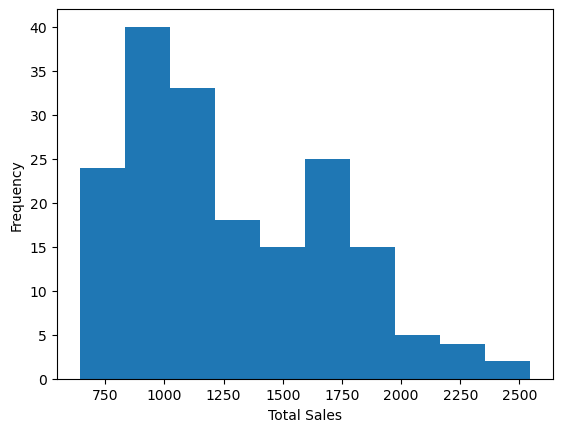

In [106]:
#statistical analysis weekday vs weekend
store1_daycategory = store1_df.groupby('transaction_date').apply(sum_totalsales) 
store2_daycategory = store2_df.groupby('transaction_date').apply(sum_totalsales)
store3_daycategory = store3_df.groupby('transaction_date').apply(sum_totalsales)

#reset index
store1_daycategory_reset = store1_daycategory.reset_index()
store2_daycategory_reset = store2_daycategory.reset_index()
store3_daycategory_reset = store3_daycategory.reset_index()

#rename totalsales column 
store1_daycategory_reset_renamed = store1_daycategory_reset.rename(columns={0: 'Total Revenue'})
store2_daycategory_reset_renamed = store2_daycategory_reset.rename(columns={0: 'Total Revenue'})
store3_daycategory_reset_renamed = store3_daycategory_reset.rename(columns={0: 'Total Revenue'})
#check normalcy 
plt.hist(store1_daycategory, bins=10)
plt.xlabel('Total Sales')
plt.ylabel('Frequency')

#extract grouped data as lists

store1_daily_revenue = store1_daycategory_reset_renamed['Total Revenue'].values
store2_daily_revenue = store2_daycategory_reset_renamed['Total Revenue'].values
store3_daily_revenue = store3_daycategory_reset_renamed['Total Revenue'].values


In [107]:

#Perform anova since sample size is decent, normalcy roughly met
f_value, p_v = stats.f_oneway(store1_daily_revenue, store2_daily_revenue, store3_daily_revenue)

print(f"The test statistic is {f_value} and the p value is {p_v}")

The test statistic is 0.3199377970446208 and the p value is 0.726331765882503


In [108]:
#Location analysis
#total revenue by store by month
print(f"The total revenue for Astoria is\n {store1_totalsales}")
print(f"The total revenue for Lower Manhattan is\n {store2_totalsales}")
print(f"The total revenue for Hell's Kitchen is\n {store3_totalsales}")


The total revenue for Astoria is
 month
1    27313.66
2    25105.34
3    32835.43
4    39477.61
5    52428.76
6    55083.11
dtype: float64
The total revenue for Lower Manhattan is
 month
1    26543.43
2    25320.05
3    32888.68
4    39159.33
5    51700.07
6    54445.69
dtype: float64
The total revenue for Hell's Kitchen is
 month
1    27820.65
2    25719.80
3    33110.57
4    40304.14
5    52598.93
6    56957.08
dtype: float64


The Astoria store's total revenue over the 6 month period is $232243.90999999997
The Lower Manhattan store's total revenue over the 6 month period is $230057.25
The Hell's Kitchen store's total revenue over the 6 month period is $236511.16999999998


<BarContainer object of 6 artists>

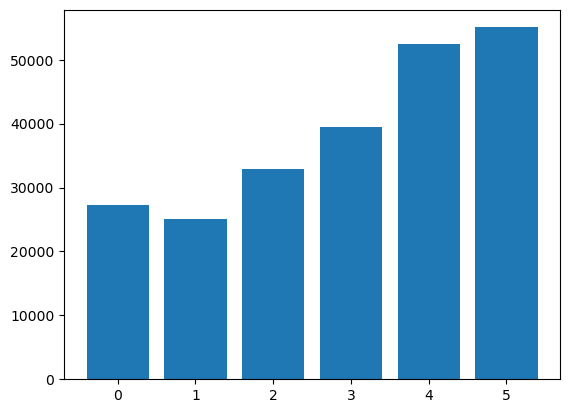

In [109]:
#statistical analysis of total revenue by store

#Create lists of monthly total revenue for each location
Astoria = [27313.66, 25105.34, 32835.43,39477.61,52428.76, 55083.11]
LM = [26543.43,25320.05,32888.68,39159.33,51700.07,54445.69]
HK = [27820.65,25719.80,33110.57,40304.14,52598.93,56957.08]

#calculate 6 month total revenues

Astoria_6month_total_revenue = sum(Astoria)
LM_6month_total_revenue = sum(LM)
HK_6month_total_revenue = sum(HK)

print(f"The Astoria store's total revenue over the 6 month period is ${Astoria_6month_total_revenue}")
print(f"The Lower Manhattan store's total revenue over the 6 month period is ${LM_6month_total_revenue}")
print(f"The Hell's Kitchen store's total revenue over the 6 month period is ${HK_6month_total_revenue}")

#Assess normality to ascertain which statistical test to use
plt.bar(range(len(Astoria)),Astoria)

In [110]:
#Since normality is likely not met or hard to evaluate given small sample size, will use Kruskal-Wallis test for monthly total revenue


#Perform Kruskal-Wallis test for monthly revenue by location 
H, p_value = stats.kruskal(Astoria, LM, HK)

#set alpha 
alpha = 0.05
print(f'Test statistic: H= {H}; P-value: p = {p_value}')
if p_value > alpha: 
    print(f'Fail to reject H0. Differences in monthly revenues between the stores are not statistically significant. Any differences that do exist could easily be due to chance rather than systematic difference.')
else:
    print(f'Reject H0')

Test statistic: H= 0.32748538011696127; P-value: p = 0.84896043973956
Fail to reject H0. Differences in monthly revenues between the stores are not statistically significant. Any differences that do exist could easily be due to chance rather than systematic difference.


In [111]:
#Astoria location Monthly Growth
#Reset the index on groupby dataframes and rename column to total revenue 
Astoria_reset = store1_totalsales.reset_index()
Astoria_df = Astoria_reset.rename(columns={0: 'Total Revenue'})
#Add month over month growth
Astoria_df['Monthly Growth'] = Astoria_df['Total Revenue'].pct_change() * 100
#Set nulls to 0 as no monthly growth for first month of operation
Astoria_df = Astoria_df.fillna(0)
Astoria_df




,month,Total Revenue,Monthly Growth
0,1,27313.66,0.000000
1,2,25105.34,-8.085039
2,3,32835.43,30.790621
3,4,39477.61,20.228698
4,5,52428.76,32.806317
5,6,55083.11,5.062775


In [112]:
#Lower Manhattan location Monthly Growth
#Reset the index on groupby dataframes and rename column to total revenue 
LM_reset = store2_totalsales.reset_index()
LM_df = LM_reset.rename(columns={0: 'Total Revenue'})
#Add month over month growth
LM_df['Monthly Growth'] = LM_df['Total Revenue'].pct_change() * 100
#Set nulls to 0 as no monthly growth for first month of operation
LM_df = LM_df.fillna(0)
LM_df


,month,Total Revenue,Monthly Growth
0,1,26543.43,0.000000
1,2,25320.05,-4.608975
2,3,32888.68,29.891845
3,4,39159.33,19.066287
4,5,51700.07,32.024910
5,6,54445.69,5.310670


In [113]:
#Hell's Kitchen location Monthly Growth
#Reset the index on groupby dataframes and rename column to total revenue 
HK_reset = store3_totalsales.reset_index()
HK_df = HK_reset.rename(columns={0: 'Total Revenue'})
#Add month over month growth
HK_df['Monthly Growth'] = HK_df['Total Revenue'].pct_change() * 100
#Set nulls to 0 as no monthly growth for first month of operation
HK_df = HK_df.fillna(0)
HK_df

,month,Total Revenue,Monthly Growth
0,1,27820.65,0.000000
1,2,25719.80,-7.551405
2,3,33110.57,28.735721
3,4,40304.14,21.725902
4,5,52598.93,30.505030
5,6,56957.08,8.285625


<Axes: title={'center': 'HK Monthly Growth'}>

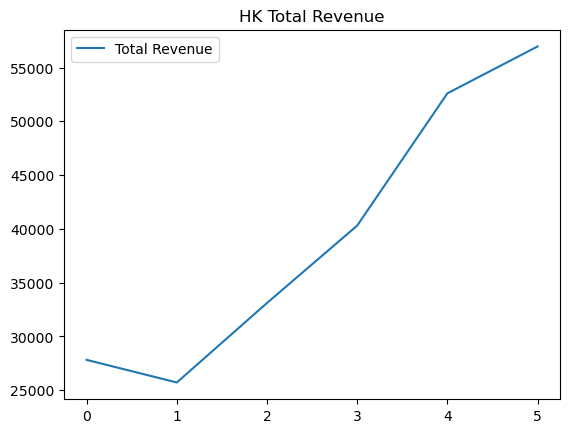

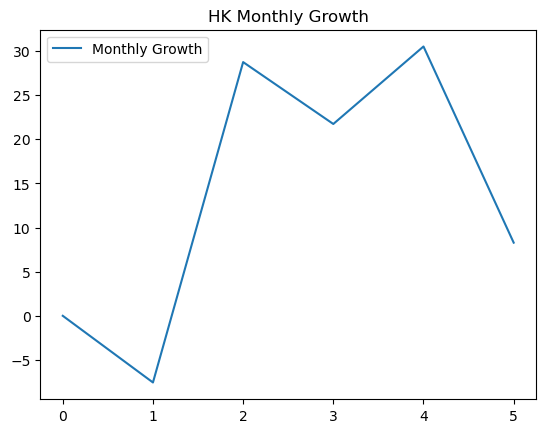

In [114]:
#plot Total Revenue and Monthly Growth
HK_df[["Total Revenue"]].plot(title='HK Total Revenue')
HK_df[["Monthly Growth"]].plot(title='HK Monthly Growth')

In [115]:
#Astoria Total Revenue and Monthly Growth descriptive statistics

Astoria_df.describe()

,month,Total Revenue,Monthly Growth
count,6.000000,6.000000,6.000000
mean,3.500000,38707.318333,13.467229
std,1.870829,12699.182657,16.948859
min,1.000000,25105.340000,-8.085039
25%,2.250000,28694.102500,1.265694
50%,3.500000,36156.520000,12.645736
75%,4.750000,49190.972500,28.150140
max,6.000000,55083.110000,32.806317


In [116]:
#Lower Manhattan Total Revenue and Monthly Growth descriptive statistics

LM_df.describe()

,month,Total Revenue,Monthly Growth
count,6.000000,6.000000,6.000000
mean,3.500000,38342.875000,13.614123
std,1.870829,12465.560752,15.620630
min,1.000000,25320.050000,-4.608975
25%,2.250000,28129.742500,1.327667
50%,3.500000,36024.005000,12.188478
75%,4.750000,48564.885000,27.185455
max,6.000000,54445.690000,32.024910


In [117]:
#Hell's Kitchen  Total Revenue and Monthly Growth descriptive statistics 
HK_df.describe()

,month,Total Revenue,Monthly Growth
count,6.000000,6.000000,6.000000
mean,3.500000,39418.528333,13.616812
std,1.870829,12992.800844,15.757431
min,1.000000,25719.800000,-7.551405
25%,2.250000,29143.130000,2.071406
50%,3.500000,36707.355000,15.005763
75%,4.750000,49525.232500,26.983266
max,6.000000,56957.080000,30.505030


<BarContainer object of 6 artists>

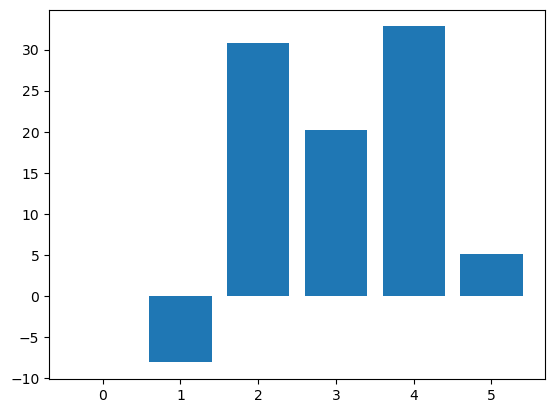

In [118]:
#statistical analysis of monthly growth by store

#Create lists of monthly growth for each location
Astoria_monthly_growth = [0.000000, -8.085039, 30.790621,20.228698,32.806317, 5.062775]
LM_monthly_growth = [0.000000,-4.608975,29.891845,19.066287,32.024910,5.310670]
HK_monthly_growth = [0.000000,-7.551405,28.735721,21.725902,30.505030,8.285625]

#Assess normality to ascertain which statistical test to use
plt.bar(range(len(Astoria_monthly_growth)),Astoria_monthly_growth)

In [119]:
#Since normality is likely not met, will use Kruskal-Wallis test for month over month growth

#Perform Kruskal-Wallis test for monthly revenue by location 
H2, p_value2 = stats.kruskal(Astoria_monthly_growth, LM_monthly_growth , HK_monthly_growth )

print(f'Test statistic: H= {H2}; P-value: p = {p_value2}')
if p_value2 > alpha: 
    print(f'Fail to reject H0. Differences in month over month growth between the stores are not statistically significant. Any differences that do exist could easily be due to chance rather than systematic difference.')
else:
    print(f'Reject H0')

Test statistic: H= 0.011744386873906616; P-value: p = 0.9941450141922755
Fail to reject H0. Differences in month over month growth between the stores are not statistically significant. Any differences that do exist could easily be due to chance rather than systematic difference.


In [120]:
#weekly analysis

store1_weekly = store1_df.groupby('weekofyear').apply(sum_totalsales)
store2_weekly = store2_df.groupby('weekofyear').apply(sum_totalsales)
store3_weekly = store3_df.groupby('weekofyear').apply(sum_totalsales)



In [121]:
#Astoria location Weekly Growth
#Reset the index on groupby dataframes and rename column to total revenue 
Astoria_reset_weekly = store1_weekly.reset_index()
Astoria_weekly_df = Astoria_reset_weekly.rename(columns={0: 'Total Revenue'})
#Add Week over Week growth
Astoria_weekly_df['Weekly Growth'] = Astoria_weekly_df['Total Revenue'].pct_change() * 100
#Set nulls to 0 as no monthly growth for first month of operation
Astoria_weekly_df = Astoria_weekly_df.fillna(0)
Astoria_weekly_df

,weekofyear,Total Revenue,Weekly Growth
0,01,5931.30,0.000000
1,02,5384.51,-9.218721
2,03,7458.85,38.524211
3,04,6046.20,-18.939247
4,05,6037.45,-0.144719
5,06,5664.55,-6.176449
6,07,6552.93,15.683152
7,08,6537.56,-0.234552
8,09,7084.25,8.362294
9,10,6945.56,-1.957723


In [122]:
#Lower Manhattan location Weekly Growth
#Reset the index on groupby dataframes and rename column to total revenue 
LM_reset_weekly = store2_weekly.reset_index()
LM_weekly_df = LM_reset_weekly.rename(columns={0: 'Total Revenue'})
#Add week over week growth
LM_weekly_df['Weekly Growth'] = LM_weekly_df['Total Revenue'].pct_change() * 100
#Set nulls to 0 as no monthly growth for first month of operation
LM_weekly_df = LM_weekly_df.fillna(0)
LM_weekly_df

,weekofyear,Total Revenue,Weekly Growth
0,01,5203.35,0.000000
1,02,6407.65,23.144705
2,03,5916.36,-7.667242
3,04,6886.53,16.398089
4,05,5227.24,-24.094718
5,06,5768.06,10.346187
6,07,6057.91,5.025086
7,08,7210.73,19.029995
8,09,6913.25,-4.125518
9,10,7236.99,4.682892


In [123]:
#HK location Weekly Growth
#Reset the index on groupby dataframes and rename column to total revenue 
HK_reset_weekly = store3_weekly.reset_index()
HK_weekly_df = HK_reset_weekly.rename(columns={0: 'Total Revenue'})
#Add week over week growth
HK_weekly_df['Weekly Growth'] = HK_weekly_df['Total Revenue'].pct_change() * 100
#Set nulls to 0 as no monthly growth for first month of operation
HK_weekly_df = HK_weekly_df.fillna(0)
HK_weekly_df

,weekofyear,Total Revenue,Weekly Growth
0,01,5874.35,0.000000
1,02,6808.19,15.896908
2,03,7243.68,6.396561
3,04,5645.48,-22.063371
4,05,5722.95,1.372248
5,06,6311.44,10.282983
6,07,6920.18,9.645026
7,08,6577.63,-4.950016
8,09,6403.70,-2.644265
9,10,7820.76,22.128769


In [124]:
#Daily analysis
#Group by day
store1_daily = store1_df.groupby('transaction_date').apply(sum_totalsales)
store2_daily= store2_df.groupby('transaction_date').apply(sum_totalsales)
store3_daily = store3_df.groupby('transaction_date').apply(sum_totalsales)

#Reset the index on groupby dataframes and rename column to total revenue 
Astoria_reset_daily = store1_daily.reset_index()
Astoria_daily_df = Astoria_reset_daily.rename(columns={0: 'Total Revenue'})

LM_reset_daily = store2_daily.reset_index()
LM_daily_df = LM_reset_daily.rename(columns={0: 'Total Revenue'})

HK_reset_daily = store3_daily.reset_index()
HK_daily_df = HK_reset_daily.rename(columns={0: 'Total Revenue'})

#Add day over day growth and set nulls to 0
Astoria_daily_df['Daily Growth'] = Astoria_daily_df['Total Revenue'].pct_change() * 100
Astoria_daily_df = Astoria_daily_df.fillna(0)

LM_daily_df['Daily Growth'] = LM_daily_df['Total Revenue'].pct_change() * 100
LM_daily_df = LM_daily_df.fillna(0)

HK_daily_df['Daily Growth'] = HK_daily_df['Total Revenue'].pct_change() * 100
HK_daily_df = HK_daily_df.fillna(0)


In [125]:
#summary statistics Astoria Total Daily Revenue and daily growth
Astoria_daily_df.describe()

,Total Revenue,Daily Growth
count,181.000000,181.000000
mean,1283.115525,2.110929
std,426.444617,19.001539
min,641.900000,-34.710581
25%,928.800000,-9.608109
50%,1175.080000,1.206692
75%,1631.930000,12.743523
max,2546.430000,76.630876


In [126]:
#summary statistics Lower Manhattan Total Daily Revenue and daily growth
LM_daily_df.describe()

,Total Revenue,Daily Growth
count,181.000000,181.000000
mean,1271.034530,2.058919
std,425.637615,18.009907
min,604.200000,-51.063468
25%,936.900000,-9.379790
50%,1150.050000,0.444134
75%,1596.800000,12.015676
max,2437.400000,59.954645


In [127]:
#summary statistics Hell's Kitchen Total Daily Revenue and daily growth
HK_daily_df.describe()

,Total Revenue,Daily Growth
count,181.000000,181.000000
mean,1306.691547,2.218075
std,441.737839,19.606083
min,612.150000,-42.217573
25%,928.450000,-9.093418
50%,1184.080000,-0.850159
75%,1598.400000,10.541385
max,2534.800000,81.220907


<Axes: title={'center': 'Astoria Daily Growth'}>

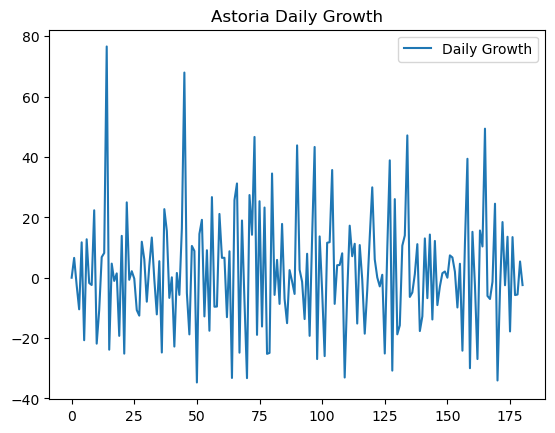

In [128]:
#Daily growth Astoria plot
Astoria_daily_df[["Daily Growth"]].plot(title='Astoria Daily Growth')

<Axes: title={'center': 'LM Daily Growth'}>

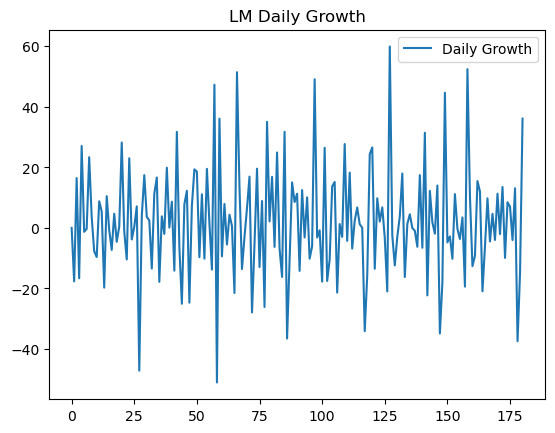

In [129]:
#Daily growth LM plot
LM_daily_df[["Daily Growth"]].plot(title='LM Daily Growth')

<Axes: title={'center': 'HK Daily Growth'}>

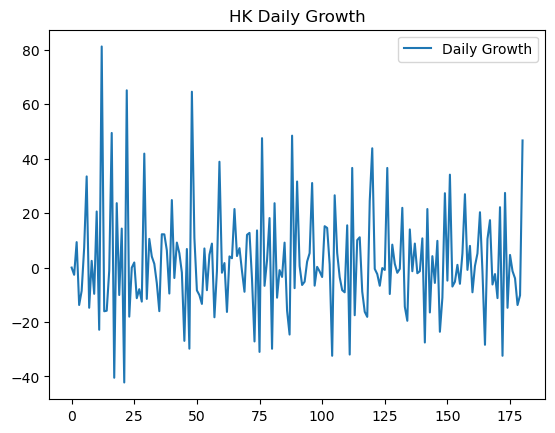

In [130]:
#Daily growth HK plot
HK_daily_df[["Daily Growth"]].plot(title='HK Daily Growth')

In [131]:
#Time series analysis of daily growth with prophet

#Prep data frames
#Remove Total revenue
prophet_Astoria_dg_df = Astoria_daily_df.drop('Total Revenue', axis = 1)
prophet_LM_dg_df = LM_daily_df.drop('Total Revenue', axis = 1)
prophet_HK_dg_df = HK_daily_df.drop('Total Revenue', axis = 1)

#rename columns 
prophet_Astoria_dg_df.columns = ['ds', 'y']
prophet_LM_dg_df.columns = ['ds', 'y']
prophet_HK_dg_df.columns = ['ds', 'y']

In [132]:
#call prophet function 

m = Prophet()
m
n = Prophet()
n
o = Prophet()
o


In [133]:
#fit the time series Prophet model
m.fit(prophet_Astoria_dg_df)
n.fit(prophet_LM_dg_df)
o.fit(prophet_HK_dg_df)

19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:06 - cmdstanpy - INFO - Chain [1] done processing
19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:06 - cmdstanpy - INFO - Chain [1] done processing
19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:06 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
# Future DataFrame to hold predictions for  Daily Growth
Astoria_future = m.make_future_dataframe(periods = 180, freq = 'D')
LM_future = n.make_future_dataframe(periods = 180, freq = 'D')
HK_future = o.make_future_dataframe(periods = 180, freq = 'D')

In [135]:
#first and last 10 days
display(Astoria_future.head(10))
display(Astoria_future.tail(10))

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
5,2023-01-06
6,2023-01-07
7,2023-01-08
8,2023-01-09
9,2023-01-10


,ds
351,2023-12-18
352,2023-12-19
353,2023-12-20
354,2023-12-21
355,2023-12-22
356,2023-12-23
357,2023-12-24
358,2023-12-25
359,2023-12-26
360,2023-12-27


In [136]:
#make forecast based on future DataFrame
Astoria_forecast = m.predict(Astoria_future)
display(Astoria_forecast.head())
display(Astoria_forecast.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,2.735707,-19.255813,28.254035,2.735707,2.735707,1.099102,1.099102,1.099102,1.099102,1.099102,1.099102,0.0,0.0,0.0,3.834808
1,2023-01-02,2.729687,-20.365939,25.343857,2.729687,2.729687,0.649238,0.649238,0.649238,0.649238,0.649238,0.649238,0.0,0.0,0.0,3.378924
2,2023-01-03,2.723667,-24.047893,21.182125,2.723667,2.723667,-3.992379,-3.992379,-3.992379,-3.992379,-3.992379,-3.992379,0.0,0.0,0.0,-1.268712
3,2023-01-04,2.717647,-13.112571,35.503017,2.717647,2.717647,7.594466,7.594466,7.594466,7.594466,7.594466,7.594466,0.0,0.0,0.0,10.312113
4,2023-01-05,2.711627,-22.028106,23.935220,2.711627,2.711627,-2.341091,-2.341091,-2.341091,-2.341091,-2.341091,-2.341091,0.0,0.0,0.0,0.370536


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
356,2023-12-23,0.586339,-23.689721,23.535582,0.585407,0.587266,-0.005896,-0.005896,-0.005896,-0.005896,-0.005896,-0.005896,0.0,0.0,0.0,0.580442
357,2023-12-24,0.580292,-22.608566,24.418798,0.579353,0.581226,1.099102,1.099102,1.099102,1.099102,1.099102,1.099102,0.0,0.0,0.0,1.679393
358,2023-12-25,0.574245,-20.654359,26.261054,0.573300,0.575187,0.649238,0.649238,0.649238,0.649238,0.649238,0.649238,0.0,0.0,0.0,1.223482
359,2023-12-26,0.568197,-27.038653,19.724784,0.567247,0.569148,-3.992379,-3.992379,-3.992379,-3.992379,-3.992379,-3.992379,0.0,0.0,0.0,-3.424181
360,2023-12-27,0.562150,-14.920818,31.226037,0.561195,0.563109,7.594466,7.594466,7.594466,7.594466,7.594466,7.594466,0.0,0.0,0.0,8.156616


In [137]:
LM_forecast = n.predict(LM_future)
display(LM_forecast.head())
display(LM_forecast.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,2.484790,-21.212678,20.539442,2.484790,2.484790,-3.470353,-3.470353,-3.470353,-3.470353,-3.470353,-3.470353,0.0,0.0,0.0,-0.985563
1,2023-01-02,2.482191,-12.840396,33.348034,2.482191,2.482191,7.017828,7.017828,7.017828,7.017828,7.017828,7.017828,0.0,0.0,0.0,9.500018
2,2023-01-03,2.479591,-27.426438,18.769201,2.479591,2.479591,-6.085501,-6.085501,-6.085501,-6.085501,-6.085501,-6.085501,0.0,0.0,0.0,-3.605910
3,2023-01-04,2.476992,-20.470107,24.612070,2.476992,2.476992,0.391968,0.391968,0.391968,0.391968,0.391968,0.391968,0.0,0.0,0.0,2.868960
4,2023-01-05,2.474392,-17.102332,25.502300,2.474392,2.474392,1.606851,1.606851,1.606851,1.606851,1.606851,1.606851,0.0,0.0,0.0,4.081243


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
356,2023-12-23,1.206142,-18.553710,25.564604,1.166395,1.242127,1.596890,1.596890,1.596890,1.596890,1.596890,1.596890,0.0,0.0,0.0,2.803033
357,2023-12-24,1.202534,-25.805011,18.868420,1.162487,1.238836,-3.470353,-3.470353,-3.470353,-3.470353,-3.470353,-3.470353,0.0,0.0,0.0,-2.267819
358,2023-12-25,1.198925,-13.213936,31.141444,1.158579,1.235680,7.017828,7.017828,7.017828,7.017828,7.017828,7.017828,0.0,0.0,0.0,8.216753
359,2023-12-26,1.195316,-26.582962,16.549645,1.154670,1.232413,-6.085501,-6.085501,-6.085501,-6.085501,-6.085501,-6.085501,0.0,0.0,0.0,-4.890185
360,2023-12-27,1.191707,-20.403299,22.381775,1.150762,1.229100,0.391968,0.391968,0.391968,0.391968,0.391968,0.391968,0.0,0.0,0.0,1.583675


In [138]:
HK_forecast = o.predict(HK_future)
display(HK_forecast.head())
display(HK_forecast.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,2.757417,-22.417992,27.717823,2.757417,2.757417,-1.031105,-1.031105,-1.031105,-1.031105,-1.031105,-1.031105,0.0,0.0,0.0,1.726312
1,2023-01-02,2.752740,-20.635156,31.074909,2.752740,2.752740,0.691955,0.691955,0.691955,0.691955,0.691955,0.691955,0.0,0.0,0.0,3.444695
2,2023-01-03,2.748063,-21.781285,31.879166,2.748063,2.748063,2.282768,2.282768,2.282768,2.282768,2.282768,2.282768,0.0,0.0,0.0,5.030831
3,2023-01-04,2.743385,-27.399845,22.963744,2.743385,2.743385,-4.722916,-4.722916,-4.722916,-4.722916,-4.722916,-4.722916,0.0,0.0,0.0,-1.979531
4,2023-01-05,2.738708,-22.328857,25.874927,2.738708,2.738708,0.178091,0.178091,0.178091,0.178091,0.178091,0.178091,0.0,0.0,0.0,2.916799


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
356,2023-12-23,0.906977,-25.342916,25.055728,0.886955,0.924525,0.394564,0.394564,0.394564,0.394564,0.394564,0.394564,0.0,0.0,0.0,1.301540
357,2023-12-24,0.901770,-25.535129,24.131949,0.881613,0.919501,-1.031105,-1.031105,-1.031105,-1.031105,-1.031105,-1.031105,0.0,0.0,0.0,-0.129335
358,2023-12-25,0.896563,-23.481325,27.447621,0.876251,0.914477,0.691955,0.691955,0.691955,0.691955,0.691955,0.691955,0.0,0.0,0.0,1.588518
359,2023-12-26,0.891356,-20.314424,28.912684,0.870877,0.909464,2.282768,2.282768,2.282768,2.282768,2.282768,2.282768,0.0,0.0,0.0,3.174124
360,2023-12-27,0.886149,-30.429090,20.705675,0.865641,0.904485,-4.722916,-4.722916,-4.722916,-4.722916,-4.722916,-4.722916,0.0,0.0,0.0,-3.836767


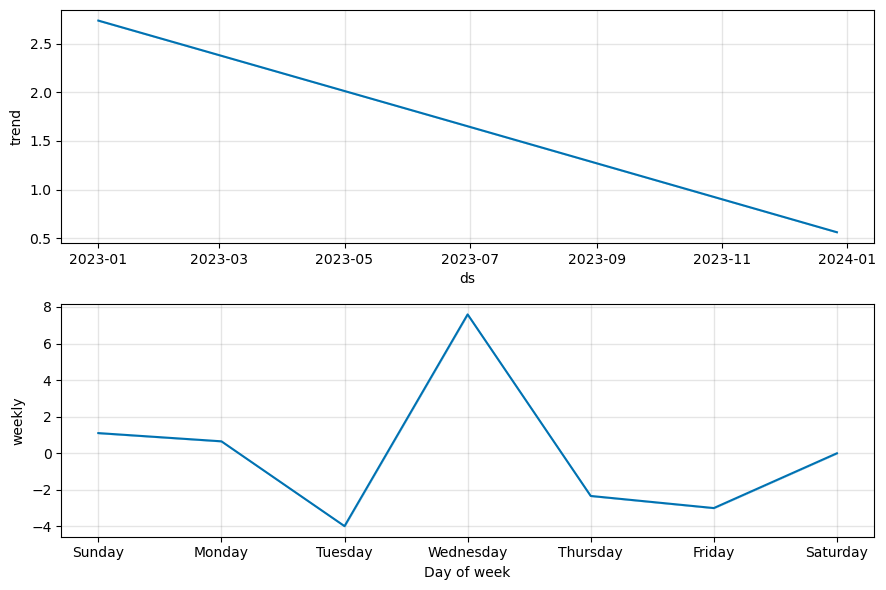

In [139]:
Astoria_daily_growth_prophet_plot = m.plot_components(Astoria_forecast)

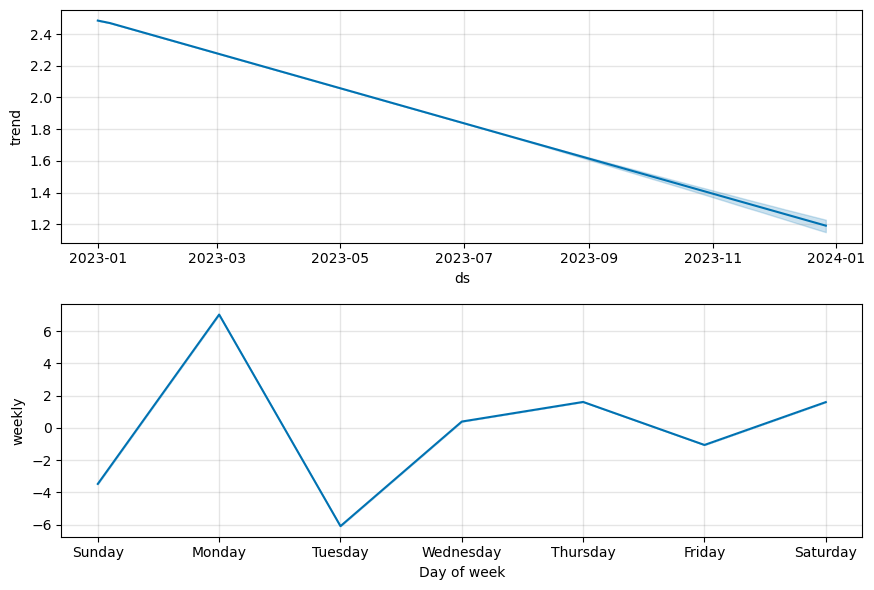

In [140]:
LM_daily_growth_prophet_plot = n.plot_components(LM_forecast)

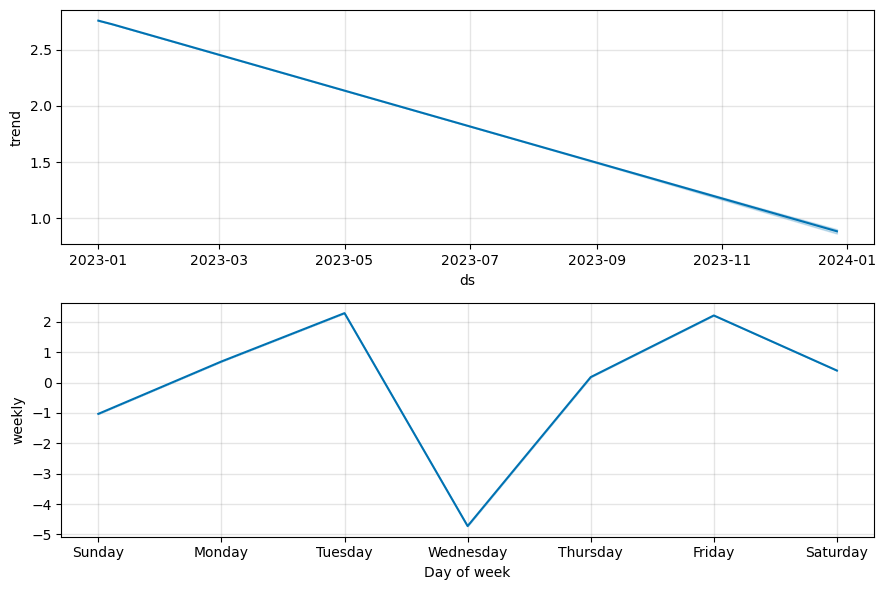

In [141]:
HK_daily_growth_prophet_plot = o.plot_components(HK_forecast)